In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

In [2]:
## Purely application of building supervised machine learning models in sci-kit learn.
## For exploratory analysis see other notebook.

In [3]:
## Load both train and test dataframes in and merge. Ideally keep the test data set
## isolated from training but for this Titanic problem, I am going to initially merge the
## two datasets to speed up imputation, feature engineering etc

In [4]:
test_titanic = pd.read_csv('test.csv')
train_titanic = pd.read_csv('train.csv')

In [5]:
test_titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
## Add variable to identify train and test dataframes and merge dataframes
test_titanic['df'] = 'Test'
train_titanic['df'] = 'Train'

titanic = pd.concat([test_titanic, train_titanic], ignore_index= True)

In [7]:
titanic.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
df              object
dtype: object

In [8]:
## Convert Passenger Class var to ordered categorical
passenger_class = pd.Categorical(titanic.Pclass, ordered= True)
passenger_class.rename_categories(['1st Class', '2nd Class', '3rd Class'], inplace= True)
titanic.Pclass = passenger_class
titanic.head()


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,df
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3rd Class,male,0,NaN,330911,Test
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3rd Class,female,1,NaN,363272,Test
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2nd Class,male,0,NaN,240276,Test
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3rd Class,male,0,NaN,315154,Test
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3rd Class,female,1,NaN,3101298,Test


In [9]:
## find missing variables
titanic.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
df                0
dtype: int64

/home/gregory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


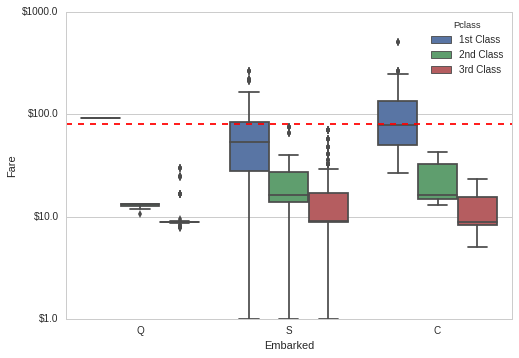

In [10]:
## Clean up missing variables
## Cabin - too many missing to impute with conviction so feature engineer Deck var where
## first letter of Cabin is Deck. Missing values encoded as n

titanic['Deck'] = titanic.Cabin.str.extract(r'(\w)\d*')
titanic.Deck = np.where(titanic.Deck.isnull(), 'n', titanic.Deck)

## Embarked - Looking at the distribution of these passenger fares with respect to passenger 
## class and port of embarkation, there is a strong case to be made for 'C' (Charbourg) being 
## the missing value of our first class passengers. The median cost of a 1st class passengers
## ticket from Charbourg is around $80 - exactly the price our missing values.

df = titanic[titanic.Embarked.notnull()]
sns.set(style = 'whitegrid')
g = sns.categorical.boxplot('Embarked', df.Fare + 1,'Pclass', data = df)
g.set_yscale('log')
g.set_ylim(top = 1000)
g.set_yticklabels(['${:.1f}'.format(y) for y in g.get_yticks()])
g.axhline(y=80, ls = '--', color = 'r');

titanic.Embarked = np.where(~titanic.Embarked.notnull(),'C',titanic.Embarked)


In [11]:
## Fare - 1 missing value

titanic[titanic.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,df,Deck
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3rd Class,male,0,NaN,3701,Test,n


In [12]:
## Third class, embarked from S. Let's take a look at the distribution

In [13]:
df_3rd_S = titanic[(titanic.Pclass == '3rd Class') & (titanic.Embarked == 'S') 
                   & (titanic.Fare.notnull()) & (titanic.Sex == 'male')]
len(df_3rd_S)

365

/home/gregory/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


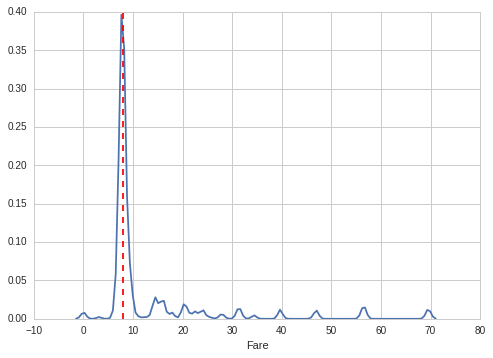

In [14]:
sns.distplot(df_3rd_S.Fare.dropna(), hist = False)
plt.axvline(x = df_3rd_S.Fare.median(), ls = '--', color = 'r')

In [15]:
titanic.loc[titanic.Fare.isnull(), 'Fare'] = df_3rd_S.Fare.median()

In [16]:
## Age - First we are going to create new variable Title which will both help in imputing
## age and an interesting variable for survival prediction.

salutations = titanic.Name.str.extract(r'\s(\w*)\.', flags= re.IGNORECASE)
salutations.value_counts()

/home/gregory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Jonkheer      1
Dona          1
Capt          1
Sir           1
Don           1
Countess      1
Lady          1
Mme           1
Name: Name, dtype: int64

In [17]:
## Can group similar titles together to decrease number of categories.
salutations[salutations.isin(['Ms', 'Mlle'])] = 'Miss'
salutations[salutations.isin(['Don', 'Jonkheer'])] = 'Sir'
salutations[salutations.isin(['Dona', 'Lady', 'Countess'])] = 'Lady'
salutations[salutations.isin(['Mme'])] = 'Mrs'
salutations[salutations.isin(['Capt', 'Major', 'Col'])] = 'Officer'
titanic['Title'] = salutations

titanic.Title.value_counts()

In [19]:
## To impute the missing values of Age, will group data set by both Title and Pclass and for
## each group, use the median value.

titanic['Age_Med_Imp'] = titanic.Age
fill_median = lambda g: g.fillna(g.median())
titanic.Age_Med_Imp = titanic.groupby(['Title', 'Pclass'])['Age_Med_Imp'].apply(fill_median)

In [20]:
## create a new variable family size

titanic['Family_Size']  = titanic.SibSp + titanic.Parch + 1

In [21]:
## create variable 'Singleton' if travelled alone
titanic['Singleton'] = (titanic.Family_Size == 1)*1

In [22]:
## create a new variable is_child (1 for passengers under the age of 14)
titanic['is_Child'] = (titanic.Age_Med_Imp <= 14)*1

In [23]:
matplotlib.style.use('ggplot')

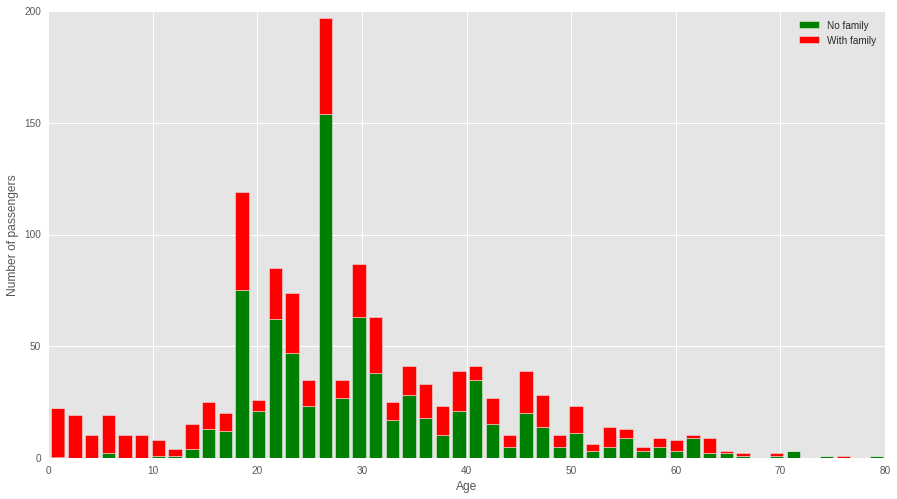

In [24]:
figure = plt.figure(figsize=(15,8))
plt.hist([titanic[titanic['Singleton']==1]['Age_Med_Imp'],titanic[titanic['Singleton']==0]['Age_Med_Imp']], histtype= 'barstacked', color = ['g','r'],
         bins = 50,label = ['No family','With family'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

In [25]:
titanic_full = titanic.copy()

In [26]:
del titanic_full['Cabin']
del titanic_full['Parch']
del titanic_full['SibSp']
del titanic_full['Age']
del titanic_full['Name']
del titanic_full['Ticket']
del titanic_full['Embarked']
titanic_full.head()

,Fare,PassengerId,Pclass,Sex,Survived,df,Deck,Title,Age_Med_Imp,Family_Size,Singleton,is_Child
0,7.8292,892,3rd Class,male,NaN,Test,n,Mr,34.5,1,1,0
1,7.0000,893,3rd Class,female,NaN,Test,n,Mrs,47.0,2,0,0
2,9.6875,894,2nd Class,male,NaN,Test,n,Mr,62.0,1,1,0
3,8.6625,895,3rd Class,male,NaN,Test,n,Mr,27.0,1,1,0
4,12.2875,896,3rd Class,female,NaN,Test,n,Mrs,22.0,3,0,0


In [27]:
## Split back to train and test

train = titanic_full[titanic_full.df == 'Train']
test = titanic_full[titanic_full.df == 'Test']
del train['df']
del test['df']

In [28]:
train_orig = train.copy()
test_orig = test.copy()

In [29]:
train.head()

,Fare,PassengerId,Pclass,Sex,Survived,Deck,Title,Age_Med_Imp,Family_Size,Singleton,is_Child
418,7.2500,1,3rd Class,male,0.0,n,Mr,22.0,2,0,0
419,71.2833,2,1st Class,female,1.0,C,Mrs,38.0,2,0,0
420,7.9250,3,3rd Class,female,1.0,n,Miss,26.0,1,1,0
421,53.1000,4,1st Class,female,1.0,C,Mrs,35.0,2,0,0
422,8.0500,5,3rd Class,male,0.0,n,Mr,35.0,1,1,0


In [30]:
test.head()

,Fare,PassengerId,Pclass,Sex,Survived,Deck,Title,Age_Med_Imp,Family_Size,Singleton,is_Child
0,7.8292,892,3rd Class,male,NaN,n,Mr,34.5,1,1,0
1,7.0000,893,3rd Class,female,NaN,n,Mrs,47.0,2,0,0
2,9.6875,894,2nd Class,male,NaN,n,Mr,62.0,1,1,0
3,8.6625,895,3rd Class,male,NaN,n,Mr,27.0,1,1,0
4,12.2875,896,3rd Class,female,NaN,n,Mrs,22.0,3,0,0


In [31]:
from sklearn import preprocessing

In [32]:
label_encoder = preprocessing.LabelEncoder()

Sex = label_encoder.fit_transform(train.Sex)
Class = label_encoder.fit_transform(train.Pclass)

train.loc[:,'Sex'] = Sex
train.loc[:,'Pclass'] = Class


/home/gregory/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
train = pd.get_dummies(train, columns = ['Deck', 'Title'], drop_first= True)

train = train.drop('PassengerId', axis = 1)

train.head()

,Fare,Pclass,Sex,Survived,Age_Med_Imp,Family_Size,Singleton,is_Child,Deck_B,Deck_C,...,Deck_T,Deck_n,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Rev,Title_Sir
418,7.2500,2,1,0.0,22.0,2,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
419,71.2833,0,0,1.0,38.0,2,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
420,7.9250,2,0,1.0,26.0,1,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
421,53.1000,0,0,1.0,35.0,2,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
422,8.0500,2,1,0.0,35.0,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [34]:
Sex = label_encoder.fit_transform(test.Sex)
Class = label_encoder.fit_transform(test.Pclass)

test.loc[:,'Sex'] = Sex
test.loc[:,'Pclass'] = Class

test = pd.get_dummies(test, ['Deck', 'Title'], drop_first= True)

pass_id = test.pop('PassengerId')

test = test.reindex(columns=train.columns, fill_value=0)

/home/gregory/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [35]:
test.drop('Survived', axis = 1, inplace= True)
test.head()

,Fare,Pclass,Sex,Age_Med_Imp,Family_Size,Singleton,is_Child,Deck_B,Deck_C,Deck_D,...,Deck_T,Deck_n,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Rev,Title_Sir
0,7.8292,2,1,34.5,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,7.0000,2,0,47.0,2,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,9.6875,1,1,62.0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,8.6625,2,1,27.0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,12.2875,2,0,22.0,3,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [36]:
X_train = train.drop('Survived', axis = 1)
y_train = train.Survived
X_test = test.copy()

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
def cv_scorer(model, folds, X, y, scoring= 'accuracy'):
    kf = sklearn.model_selection.StratifiedKFold(folds, True)
    scores = sklearn.model_selection.cross_val_score(model, X, y, scoring= scoring, cv = kf)
    return np.mean(scores)

In [39]:
clf = LogisticRegression()
score = cv_scorer(clf, 5, X_train,y_train)
print(score)

0.828225855357


In [40]:
# pipeline of StandardScaler and LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [41]:
# grid search for best combination of C and penalty
from sklearn.model_selection import GridSearchCV
C_range = 10.**np.arange(-2, 3)
penalty_options = ['l1']
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_log_loss')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'logisticregression__penalty': ['l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [42]:
# examine the best model
print (grid.best_score_)
print (grid.best_params_)

-0.421429967818
{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}


In [43]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty= 'l1', C= 1.0))
cv_scorer(pipe, 10, X_train, y_train)

0.82597548518896835

In [44]:
pipe.fit(X_train, y_train)
print(sklearn.metrics.accuracy_score(y_train, pipe.predict(X_train)))
predictions = pipe.predict(X_test)

0.83950617284


In [45]:
def make_sub(filename, predicts):
    submission = pd.DataFrame({"PassengerId":pass_id,
                           "Survived":predicts.astype(int)})
    submission.to_csv("{}.csv".format(filename),index=False) 

In [46]:
make_sub('logistic_reg_l1', predictions)

In [47]:
## K-NN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
knn = KNeighborsClassifier(n_neighbors= 5)

In [50]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [51]:
y_pred = knn.predict(X_train)

In [52]:
sklearn.metrics.accuracy_score(y_train, y_pred)

0.81481481481481477

In [53]:
cv_scorer(knn, 5, X_train, y_train)

0.73398692879994132

In [54]:
knn = KNeighborsClassifier()
knn.get_params().keys()

dict_keys(['leaf_size', 'n_jobs', 'n_neighbors', 'metric_params', 'p', 'weights', 'algorithm', 'metric'])

In [55]:
K_range = np.arange(1, 30)
param_grid = dict(n_neighbors=K_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [56]:
grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [57]:
grid.best_score_

0.73288439955106621

In [58]:
grid.cv_results_['param_n_neighbors']

masked_array(data = [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False],
       fill_value = ?)

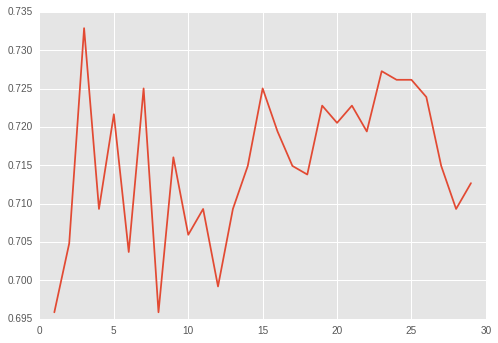

In [59]:
f, ax = plt.subplots()
sns.plt.plot(K_range, grid.cv_results_['mean_test_score'])

In [60]:
## From the graph of complexity (k-value) vs test accuracy we can see that k=7 and k = 24 perform the best. We prefer
## a simpler model so lets take k = 24.

In [61]:
knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

In [62]:
make_sub('KNN_24', preds)

In [63]:
## Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

In [65]:
Feature_vars = ['Fare', 'Pclass', 'Sex', 'Deck', 'Title', 'Age_Med_Imp', 'Family_Size', 'Singleton', 'is_Child']
train_orig[Feature_vars].head(),test_orig[Feature_vars].head()

(        Fare     Pclass     Sex Deck Title  Age_Med_Imp  Family_Size  \
 418   7.2500  3rd Class    male    n    Mr         22.0            2   
 419  71.2833  1st Class  female    C   Mrs         38.0            2   
 420   7.9250  3rd Class  female    n  Miss         26.0            1   
 421  53.1000  1st Class  female    C   Mrs         35.0            2   
 422   8.0500  3rd Class    male    n    Mr         35.0            1   
 
      Singleton  is_Child  
 418          0         0  
 419          0         0  
 420          1         0  
 421          0         0  
 422          1         0  ,
       Fare     Pclass     Sex Deck Title  Age_Med_Imp  Family_Size  Singleton  \
 0   7.8292  3rd Class    male    n    Mr         34.5            1          1   
 1   7.0000  3rd Class  female    n   Mrs         47.0            2          0   
 2   9.6875  2nd Class    male    n    Mr         62.0            1          1   
 3   8.6625  3rd Class    male    n    Mr         27.0         

In [66]:
Sex = label_encoder.fit(train_orig.Sex)
train_orig.loc[:,'Sex'] = Sex.transform(train_orig.Sex)
test_orig.loc[:,'Sex'] = Sex.transform(test_orig.Sex)

Class = label_encoder.fit(train_orig.Pclass)
train_orig.loc[:,'Pclass'] = Class.transform(train_orig.Pclass)
test_orig.loc[:,'Pclass'] = Class.transform(test_orig.Pclass)

Deck = label_encoder.fit(train_orig.Deck)
train_orig.loc[:,'Deck'] = Deck.transform(train_orig.Deck)
test_orig.loc[:,'Deck'] = Deck.transform(test_orig.Deck)

Title = label_encoder.fit(train_orig.Title)
train_orig.loc[:,'Title'] = Title.transform(train_orig.Title)
test_orig.loc[:,'Title'] = Title.transform(test_orig.Title)

In [67]:
train_orig[Feature_vars].head(),test_orig[Feature_vars].head()

(        Fare  Pclass  Sex  Deck  Title  Age_Med_Imp  Family_Size  Singleton  \
 418   7.2500       2    1     8      4         22.0            2          0   
 419  71.2833       0    0     2      5         38.0            2          0   
 420   7.9250       2    0     8      3         26.0            1          1   
 421  53.1000       0    0     2      5         35.0            2          0   
 422   8.0500       2    1     8      4         35.0            1          1   
 
      is_Child  
 418         0  
 419         0  
 420         0  
 421         0  
 422         0  ,
       Fare  Pclass  Sex  Deck  Title  Age_Med_Imp  Family_Size  Singleton  \
 0   7.8292       2    1     8      4         34.5            1          1   
 1   7.0000       2    0     8      5         47.0            2          0   
 2   9.6875       1    1     8      4         62.0            1          1   
 3   8.6625       2    1     8      4         27.0            1          1   
 4  12.2875       2    0 

In [68]:
dt = DecisionTreeClassifier()
cv_scorer(dt, 10, train_orig[Feature_vars], train_orig.Survived)

0.77679945522642158

In [69]:
## Lets try to tune some of the hyper parameters via a cross validated grid search

In [70]:
dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 15, 20],
              "max_depth": [None, 2, 5, 10, 15],
              "min_samples_leaf": [1, 5, 10, 20],
              "max_leaf_nodes": [None, 5, 10, 20, 30],
              }
grid = GridSearchCV(dt, param_grid, scoring = 'accuracy', cv = 10)
grid.fit(train_orig[Feature_vars], train_orig.Survived)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [None, 5, 10, 20, 30], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 10, 15], 'min_samples_split': [2, 10, 15, 20], 'min_samples_leaf': [1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [71]:
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=30, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [72]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [73]:
dt = DecisionTreeClassifier(**grid.best_params_)
dt.fit(train_orig[Feature_vars], train_orig.Survived)
print(sklearn.metrics.accuracy_score(train_orig.Survived, dt.predict(train_orig[Feature_vars])))
print(cv_scorer(dt, 10,train_orig[Feature_vars], train_orig.Survived))
preds = dt.predict(test_orig[Feature_vars])

0.878787878788
0.824990069232


In [74]:
make_sub('decision_tree_tuned', preds)

In [75]:
## Random Forest

In [76]:
train_orig[Feature_vars].shape

(891, 9)

In [77]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train_orig[Feature_vars], train_orig.Survived)

features = pd.DataFrame()
features['feature'] = train_orig[Feature_vars].columns
features['importance'] = clf.feature_importances_

features.sort_values('importance', ascending=False)

,feature,importance
2,Sex,0.255532
0,Fare,0.239304
5,Age_Med_Imp,0.199425
1,Pclass,0.090282
3,Deck,0.065069
6,Family_Size,0.058079
4,Title,0.050550
8,is_Child,0.025407
7,Singleton,0.016350


In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
rv = RandomForestClassifier(max_features=None)
parameter_grid = {
                 'max_depth' : [4,5,6,7,8],
                 'n_estimators': [200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = sklearn.model_selection.StratifiedKFold(10)

grid = GridSearchCV(rv,param_grid=parameter_grid,cv=cross_validation, scoring= 'accuracy')

grid.fit(train_orig[Feature_vars], train_orig.Survived)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8], 'n_estimators': [200, 210, 240, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [80]:
print('Best score: {}'.format(grid.best_score_))
print('Best parameters: {}'.format(grid.best_params_))

Best score: 0.8406285072951739
Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200}


In [81]:
rv =RandomForestClassifier( **grid.best_params_)
rv.fit(train_orig[Feature_vars], train_orig.Survived)
print(sklearn.metrics.accuracy_score(train_orig.Survived, rv.predict(train_orig[Feature_vars])))
print(cv_scorer(rv, 10, train_orig[Feature_vars], train_orig.Survived))
preds = rv.predict(test_orig[Feature_vars])

0.914702581369
0.820495970945


In [82]:
make_sub('RF_test', preds)

In [83]:
###

In [84]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_

features.sort_values('importance', ascending=False)

,feature,importance
0,Fare,0.239711
3,Age_Med_Imp,0.196317
2,Sex,0.117681
18,Title_Mr,0.112352
1,Pclass,0.071112
4,Family_Size,0.061047
17,Title_Miss,0.044249
19,Title_Mrs,0.038819
14,Deck_n,0.038429
5,Singleton,0.016368


In [85]:
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(X_train)
train_new.shape

(891, 7)

In [86]:
test_new = model.transform(X_test)
test_new.shape

(418, 7)

In [87]:
lr = LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'] }
fitmodel = sklearn.model_selection.GridSearchCV(lr, parameters, cv = 5,scoring= 'accuracy')
fitmodel.fit(train_new, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [88]:
fitmodel.best_score_, fitmodel.best_estimator_, fitmodel.best_params_

(0.81593714927048255,
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 100, 'penalty': 'l1'})

In [89]:
predicts = fitmodel.predict(test_new)

In [90]:
make_sub('Logistic_feature_selection', predicts)

In [91]:
## 